# Задение 3

## Предобработка данных

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel("Ex3.xlsx")
df.head(3)

,Date,VR1,VR2
0,2023-10-16,43154.18,5882.5
1,2023-10-13,43265.49,6048.1
2,2023-10-12,43298.45,5645.1


In [3]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date']) 

df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2183 entries, 2015-01-12 to 2023-10-16
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VR1     2183 non-null   float64
 1   VR2     2183 non-null   float64
dtypes: float64(2)
memory usage: 51.2 KB


## 3.1. Требования Банка России к кредитным организациям по кредитам (по оставшимся до погашения срокам), млн руб. (на начало дня), сроки, оставшиеся до погашения, от 181 до 365 дней - 12.01.2015 – 18.06.2019 (VR1)

### Выбираем нужный период для анализа

In [5]:
# Обрезаем датасет
start_date_VR1 = pd.to_datetime('2015-01-12')
end_date_VR1 = pd.to_datetime('2019-06-18')

df_result_VR1 = df.loc[start_date_VR1:end_date_VR1]

In [6]:
df_result_VR1.shape

(1096, 2)

In [7]:
df_result_VR1 = df_result_VR1.drop(columns="VR2")

### 3.1.2. Так как временные ряды имеют пропуски (по нерабочим дням), восстановите пропущенные значения. Обоснуйте и опишите метод, который Вы будете использовать для восстановления пропущенных значений.

In [8]:
df_result_VR1.index = pd.to_datetime(df_result_VR1.index)
df_result_VR1 = df_result_VR1.asfreq('D')
df_result_VR1 = df_result_VR1.interpolate(method='time')  # Интерполяция по времени

Методом заполнения пропусков была выбрана интерполяция с параметром "Time".
Данный параметр был выбран исходя из того, что он предназначен для работы с ежедневными и более частыми данными (Works on daily and higher resolution data to interpolate given length of interval.)

[Источник: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html]


В целом, метод интерполяции был выбран потому, что интерполяция позволяет заполнить пропущенные значения на основе соседних значений (как мы обсуждали на занятии - значения у нас пропущены по празникам и выходным, что является отличным для нас вариантом, ведь вряд ли между, например, пятницей и понедельником будет большой разрыв значений, а, возможно, в выходные они вообще не меняются, что как раз даст нам тот же - реальный - результат).

[Источник: https://habr.com/ru/companies/mvideo/articles/769190/]

In [9]:
print((pd.to_datetime(end_date_VR1) - pd.to_datetime(start_date_VR1)).days + 1) #проверка, за какое количество дней должны быть данные

1619


In [10]:
df_result_VR1.shape # совпадает

(1619, 1)

In [11]:
df_result_VR1.to_excel("Ex3_VR1_fillData.xlsx")

### 3.1.1. Постройте графики, визуализирующие каждый временной ряд. Охарактеризуйте временные ряды, присутствуют ли в них тренд, сезонность или цикл? 

In [12]:
fig = px.line(
    df_result_VR1, 
    x=df_result_VR1.index, 
    y=df_result_VR1['VR1'], 
    labels={'Date': 'Период', 'VR1': 'млн.рублей'}, 
    title='Требования Банка России к кредитным организациям по кредитам (по оставшимся до погашения срокам), млн руб. (на начало дня), сроки, оставшиеся до погашения, от 181 до 365 дней'
)

fig.update_layout(
    xaxis=dict(title='Период', tickformat='%Y-%m-%d'),
    yaxis=dict(title='млн.рублей'),
    template='plotly_white'
)

fig.show()

По данному графику мы видим, что в 2015 году наблдается резкое снижение объема требований с уровня около 800 000 000 000 руб. до 12 226 000 000 руб. к концу года. В 2016 году опять же наблюдается резкий рост до 500 000 000 000 рублей, после чего сумма снижается и стабилизируется на уровне в районе 50 000 000 000 рублей.

In [13]:
decomposition = seasonal_decompose(df_result_VR1, model='additive')
# Извлечение компонентов тренда, сезонности и остатков
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = make_subplots(
    rows=4, cols=1, 
    shared_xaxes=True,
    subplot_titles=[
        'Исходный временной ряд',
        'Компонент тренда',
        'Компонент сезонности',
        'Остаточные компоненты'
    ]
)

# График исходного временного ряда
fig.add_trace(
    go.Scatter(x=df_result_VR1.index, y=df_result_VR1['VR1'], mode='lines', name='Исходный ряд'),
    row=1, col=1
)

# График компонента тренда
fig.add_trace(
    go.Scatter(x=df_result_VR1.index, y=trend, mode='lines', name='Тренд'),
    row=2, col=1
)

# График компонента сезонности
fig.add_trace(
    go.Scatter(x=df_result_VR1.index, y=seasonal, mode='lines', name='Сезонность'),
    row=3, col=1
)

# График остаточных компонентов
fig.add_trace(
    go.Scatter(x=df_result_VR1.index, y=residual, mode='lines', name='Остатки'),
    row=4, col=1
)

fig.update_layout(
    height=1400, 
    width=1700
)

fig.show()

Касательно тренда, можно отметить, что он схож силуэтом с иходным временным рядом. Как отмечалось ранее - наблюдается снижение тренда с начала 2015 до середины 2016 года, после чего значения стабилизируются на низком уровне.

Если говорить о сезонности, то она стабильна на протяжении всего анализируемого периода, при этом, если приблизить график и посмотреть на какие дни приходятся пики, то видно, что сезонность еженедельная, каждый пик повторяется с одной и той же периодичностью -  7 дней. Можно было бы сказать, что это цикличность, однако по графику четко вино, что колебания больше объясняются сезонными эффектами, а не длительными циклами.

Про цикличность можно сказать, что она отсуствует.

Про остатки можно отметить, что они демонстрируют небольшие выбросы в начале периода, но затем стабилизируются на низком уровне, что говорит об адекватном выделении тренда и сезонности. 

In [41]:
fig = go.Figure()

# Исходный временной ряд
fig.add_trace(
    go.Scatter(
        x=df_result_VR1.index,
        y=df_result_VR1['VR1'],
        mode='lines',
        name='Исходные данные',
        line=dict(color='blue')
    )
)

# Скользящее среднее за 7 дней
rolling_mean = df_result_VR1.rolling(7).mean()
fig.add_trace(
    go.Scatter(
        x=df_result_VR1.index,
        y=rolling_mean['VR1'],
        mode='lines',
        name='Скользящее среднее (7 дней)',
        line=dict(color='red')
    )
)

# Скользящее стандартное отклонение за 7 дней
rolling_std = df_result_VR1.rolling(7).std()
fig.add_trace(
    go.Scatter(
        x=df_result_VR1.index,
        y=rolling_std['VR1'],
        mode='lines',
        name='Скользящее стандартное отклонение (7 дней)',
        line=dict(color='black')
    )
)

fig.update_layout(
    title='Исходные данные, скользящее среднее и стандартное отклонение (7 дней)',
    xaxis_title='Период',
    yaxis_title='млн.рублей',
    height=700,
    width=1700
)

fig.show()

Взяла "разрыв" 7 дней, так как была замечена сезонность на этом периоде и стало инетерсно посмотреть, что со скользящими показателями на этом же периоде.

По скользящему среднему можно сказать, что оно неплохо сглаживает исходные данные, показывая общий тренд без резких выбросов.
А по скользящему стандартному отклонению можно (как и большинства предыдущих показателей) отметить высокие пики за период с начала 2015 года по середину 2016 года, после чего стандартное отклонение становится низким (данные стабилизируются, колебания уменьшаются).

### 3.1.3. Преобразуйте временные ряды к стационарному виду. Обоснуйте и опишите методы, которые Вы использовали. Приведите графики и результаты статистических тестов, подтверждающих, что ряд стал стационарным. 

#### Тест Дики — Фуллера на стационарность

In [15]:
from statsmodels.tsa.stattools import adfuller #Тест Дики — Фуллера на стационарность 
adft = adfuller(df_result_VR1["VR1"])
print('p-value: ', adft[1])
#Если p-value<0.05, то ряд стационарный

p-value:  0.0007185709644340488


Тест Дики-Фуллера - это распространённый в статистике тест, который используется для проверки того, является ли временной ряд статиционарным. Данный временной ряд можно назвать стационарны, если он не имеет тенденции, демонстрирует постоянную дисперсию во времени и постоянно следует структуре автокорреляции.

Задействованы следующие гипотезы:

H0: Временной ряд считается нестационарным. Проще говоря, можно сказать, что он в некоторой степени зависит от времени и не имеет постоянной дисперсии в течение определённого периода времени.
H1: Временной ряд считается стационарным.
Теперь, если значение p в результате этого теста окажется меньше определённого уровня (например, p-val = 0,05), то в таких случаях мы можем отвергнуть нулевую гипотезу и прийти к выводу, что временной ряд является стационарным.

Источник: [https://www.geeksforgeeks.org/how-to-perform-an-augmented-dickey-fuller-test-in-r/]

Вывод: ряд является стационарным, и ему не требуется дифференциация

### 3.1.4. Постройте и опишите коррелограммы (графики автокорреляционной функции и частной автокорреляционной функции) для 2-х временных рядов.

In [16]:
for i in range(1, 22): # пройдем циклом по автокорреляциям от 1 до 21 дней (три недели)
    autocorrelation_lag = df_result_VR1['VR1'].autocorr(lag=i)
    print(f"{i} Day Lag: ", autocorrelation_lag)

1 Day Lag:  0.9919458298415891
2 Day Lag:  0.9843232251689952
3 Day Lag:  0.9765178063656741
4 Day Lag:  0.9684338894088226
5 Day Lag:  0.9602870747134099
6 Day Lag:  0.951722995389899
7 Day Lag:  0.9433459105639652
8 Day Lag:  0.9348580075388858
9 Day Lag:  0.9262287857386989
10 Day Lag:  0.9174475233828565
11 Day Lag:  0.9084881800852955
12 Day Lag:  0.8994719319050818
13 Day Lag:  0.8904278529322947
14 Day Lag:  0.8812894587276774
15 Day Lag:  0.8720007026906587
16 Day Lag:  0.8627071103719589
17 Day Lag:  0.8534026072478317
18 Day Lag:  0.8439952262208061
19 Day Lag:  0.8375458886555951
20 Day Lag:  0.8311494232292572
21 Day Lag:  0.8248302646540588


Автокорреляция постепенно уменьшается с увеличением лага, но остаётся высокой даже на 21 день (0.82). Это может говорить о длительной памяти в данных — значения в будущем зависят от прошлых значений.

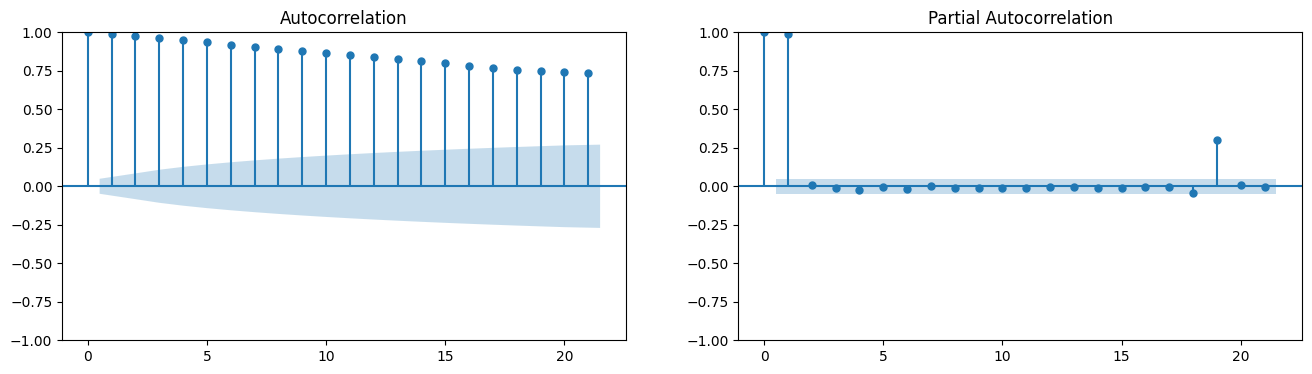

In [17]:
fig, axes = plt.subplots(1,2,figsize=(16,4), dpi= 100)
plot_acf(df_result_VR1['VR1'], lags = 21, ax=axes[0])
plot_pacf(df_result_VR1['VR1'], lags = 21, ax=axes[1])
plt.show()

По полученным графикам можно отметить следующее:
1. График Autocorrelation. Этот график показывает степень автокорреляции временного ряда на лагах от 1 до 21. Голубая область — это доверительный интервал. Если точки находятся внутри интервала, автокорреляция считается статистически незначимой.
На первом лаге видна сильная положительная корреляция (примерно 1), что согласуется с ранее рассчитанным значением автокорреляции, которая постепенно снижается, но находится за пределами голубой области и считается статистически значимой

2. График Partial Autocorrelation. График PACF показывают связь между текущим значением ряда и его значениями на определенном лаге, исключая влияние промежуточных лагов. 
Лаг 1 имеет высокое положительное значени, начиная со 2 лага и далее показатель снижается.

Источники:

[https://itsudit.medium.com/deciphering-acf-and-pacf-plots-a-guide-to-time-series-forecasting-3323948935fb]

[https://medium.com/analytics-vidhya/interpreting-acf-or-auto-correlation-plot-d12e9051cd14]

### 3.1.5. По каждому временному ряду разбейте выборку на обучающую и тестовую (обоснуйте выбор временного интервала для тестовой выборки). На основе обучающей выборки идентифицируйте параметры модели АРПСС (ARIMA) Какие параметры модели p, d и q Вы будете использовать и почему? Оцените качество модели. Насколько хорошо она предсказывает значения тестовой выборки?

In [18]:
split_date = '2018-07-01' # у нас данные за 4,5 года - возьмем 1 год в качестве тестовой выборки

train = df_result_VR1[df_result_VR1.index < split_date]

test = df_result_VR1[df_result_VR1.index >= split_date]

In [42]:
fig = go.Figure()

# Обучающая выборка (Train)
fig.add_trace(
    go.Scatter(
        x=train.index,
        y=train['VR1'],
        mode='lines',
        name='Обучающая выборка',
        line=dict(color='black')
    )
)

# Тестовая выборка (Test)
fig.add_trace(
    go.Scatter(
        x=test.index,
        y=test['VR1'],
        mode='lines',
        name='Тестовая выборка',
        line=dict(color='red')
    )
)

fig.update_layout(
    title='Обучающая и тестовая выборки по данным о требованиях Банка России к кредитным организациям по кредитам',
    xaxis_title='Период',
    yaxis_title='млн.рублей',
    height=500,
    width=1700
)

fig.show()


In [53]:
test

,VR1,diff
Date,,
2018-07-01,38215.036667,2122.173333
2018-07-02,40337.210000,2122.173333
2018-07-03,40329.760000,-7.450000
2018-07-04,40529.500000,199.740000
2018-07-05,41980.650000,1451.150000
...,...,...
2019-06-14,34366.170000,-294.140000
2019-06-15,34108.500000,-257.670000
2019-06-16,33850.830000,-257.670000


### 3.1.6. Используя модель ARIMA, постройте прогноз 2-х временных рядов на 3 года вперёд от даты окончания временного диапазона (например, если у Вас временной диапазон 12.12.2013–29.12.2017, то до 29.12.2020, если у Вас временной диапазон 02.10.2017 – 17.11.2022, то до 17.11.2025), приведите их графики.

#### ARIMA

In [20]:
model = auto_arima(train["VR1"], trace=True, error_action='ignore', suppress_warnings=True)
res = model.fit(train["VR1"])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=28881.752, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28874.602, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28876.029, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=28876.041, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=28873.463, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=28878.021, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.741 seconds


Наилучшей моделью получилась модель ARIMA (ARIMA - это модель ARMA c p авторегрессионными лагами, q лагами скользящего среднего и дифференциацией порядка d.) p = 0, d = 1, q = 0.
Выбранные значения указывают, что наилучшая модель имеет следующие параметры:

- Количество авторегрессионными лагов = 0 (нет авторегрессии).
- Дифференциация первого порядка (данные подвергнуты одному дифференцированию).
- Количество лагов скользящего среднего = 0 (нет компоненты скользящего среднего).

In [21]:
forecast = res.predict(n_periods=365*3+1)

In [22]:
date_list = pd.date_range(start='2019-06-19', end='2022-06-18', freq='D')

In [23]:
forecast = forecast.reset_index()
forecast['date'] = date_list
forecast.set_index('date', inplace=True)
forecast = (forecast.drop(columns = "index"))
forecast.rename(columns={0: 'Predictions'}, inplace=True)

In [43]:
fig = go.Figure()

# Обучающая выборка (Train)
fig.add_trace(
    go.Scatter(
        x=train.index,
        y=train['VR1'],
        mode='lines',
        name='Train',
        line=dict(color='blue')
    )
)

# Тестовая выборка (Test)
fig.add_trace(
    go.Scatter(
        x=test.index,
        y=test['VR1'],
        mode='lines',
        name='Test',
        line=dict(color='orange')
    )
)

# Прогноз (Forecast)
fig.add_trace(
    go.Scatter(
        x=forecast.index,
        y=forecast["Predictions"],
        mode='lines',
        name='Prediction',
        line=dict(color='green')
    )
)

fig.update_layout(
    title='Прогнозные суммы требования Банка России к кредитным организациям',
    xaxis_title='Период',
    yaxis_title='Млню рублей',
    height=500,
    width=1700
)

# Показ графика
fig.show()

Как мы видим модель спрогнозировала стабильно практическки одно и тоже значение

### 3.1.7. Проверьте с помощью соответствующих критериев адекватность (независимость и нормальность распределения остатков) каждой прогнозной модели для 2-х временных рядов, оцените качество прогнозной модели.

In [227]:
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1266
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -14435.731
Date:                Mon, 23 Dec 2024   AIC                          28873.463
Time:                        21:17:50   BIC                          28878.606
Sample:                    01-12-2015   HQIC                         28875.395
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.778e+08   1.31e+06    364.602      0.000    4.75e+08     4.8e+08
Ljung-Box (L1) (Q):                   1.17   Jarque-Bera (JB):           9210927.60
Prob(Q):                              0.28   Pr

Рассмотрим полученные коэффициенты модели:

В модели имеется одна переменная (sigma2) и она является статистически значимой, так как их p-value < 0.05.

- sigma2 = 4.778e+08 . Это дисперсия остатков модели, она имеет высокое значение, что связано с высокими значениями в исходных данных (Требования Банка России к кредитным организациям).

Оценить саму модель, к сожалению, не получится, так как спрогнозированные значения не имеют общих интервалов с тестовой выборкой. Поэтому мы оценим остатки

In [44]:
residuals = pd.DataFrame(res.resid())
residuals.index = pd.to_datetime(residuals.index)

# Создаем график остатков
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=residuals.index,
        y=residuals[0],
        mode='lines',
        name='Residuals',
        line=dict(color='blue')
    )
)

fig.update_layout(
    title='Остатки модели',
    xaxis_title='Период',
    yaxis_title='Остатки, млн. рублей',
    height=500,
    width=1700
)

fig.show()


На графике остатков видны выбросы в начале ряда, причём некоторые из них достигают значений около 800 000 млн. рублей.
Также, можно отметить, что большинство остатков сосредоточено около 0, но наличие крупных выбросов указывает на то, что модель недостаточно адаптирована к резким изменениям в данных.
После первых значений остатки становятся более стабильными, что может свидетельствовать об улучшении соответствия модели в поздние периоды.

<Axes: ylabel='Density'>

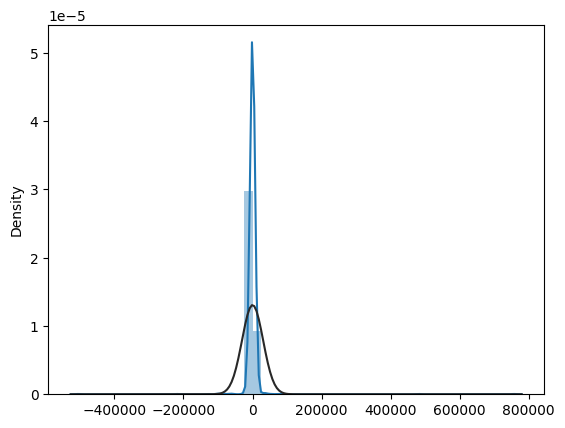

In [26]:
from scipy import stats 
sns.distplot(residuals, fit=stats.norm) 

По графику распределния остатков можно сказать следующее:

- Распределение остатков сильно заострено (остроконечное) — наблюдается высокий пик вблизи 0, что указывает на скопление значений вокруг среднего;
- Синяя кривая отклоняется от чёрной кривой, которая отображает нормальное распределение, что говорит о несоответствии остатков нормальному распределению;
- Видны заметные выбросы.

In [ ]:
forecast.columns = ['VR1']

final_df = pd.concat([df_result_VR1["VR1"], forecast], ignore_index=False)
final_df.to_excel("Ex3_VR1_predictData.xlsx")

## 3.2. Сальдо операций Банка России по предоставлению / абсорбированию ликвидности, млрд руб. - 03.07.2017 – 30.06.2021 (VR2)

### Выбираем нужный период для анализа

In [27]:
# Обрезаем датасет
start_date_VR2 = pd.to_datetime('2017-07-03')
end_date_VR2 = pd.to_datetime('2021-06-30')

df_result_VR2 = df.loc[start_date_VR2:end_date_VR2]
df_result_VR2 = df_result_VR2.drop(columns="VR1")

### 3.1.2. Так как временные ряды имеют пропуски (по нерабочим дням), восстановите пропущенные значения. Обоснуйте и опишите метод, который Вы будете использовать для восстановления пропущенных значений.

In [28]:
df_result_VR2.index = pd.to_datetime(df_result_VR2.index)
df_result_VR2 = df_result_VR2.asfreq('D')
df_result_VR2 = df_result_VR2.interpolate(method='time')  # Интерполяция по времени

Методом заполнения пропусков была выбрана интерполяция с параметром "Time".
Данный параметр был выбран исходя из того, что он предназначен для работы с ежедневными и более частыми данными (Works on daily and higher resolution data to interpolate given length of interval.)

[Источник: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html]


В целом, метод интерполяции был выбран потому, что интерполяция позволяет заполнить пропущенные значения на основе соседних значений (как мы обсуждали на занятии - значения у нас пропущены по празникам и выходным, что является отличным для нас вариантом, ведь вряд ли между, например, пятницей и понедельником будет большой разрыв значений, а, возможно, в выходные они вообще не меняются, что как раз даст нам тот же - реальный - результат).

[Источник: https://habr.com/ru/companies/mvideo/articles/769190/]

In [29]:
print((pd.to_datetime(end_date_VR2) - pd.to_datetime(start_date_VR2)).days + 1) #проверка, за какое количество дней должны быть данные

1459


In [30]:
df_result_VR2.shape # совпадает

(1459, 1)

In [273]:
df_result_VR2.to_excel("Ex3_VR2_fillData.xlsx")

### 3.1.1. Постройте графики, визуализирующие каждый временной ряд. Охарактеризуйте временные ряды, присутствуют ли в них тренд, сезонность или цикл? 

In [31]:
fig = px.line(
    df_result_VR2, 
    x=df_result_VR2.index, 
    y=df_result_VR2['VR2'], 
    labels={'Date': 'Период', 'VR2': 'млн.рублей'}, 
    title='Сальдо операций Банка России по предоставлению / абсорбированию ликвидности'
)

fig.update_layout(
    xaxis=dict(title='Период', tickformat='%Y-%m-%d'),
    yaxis=dict(title='млрд.рублей'),
    template='plotly_white'
)

fig.show()

По данному графику видно, что сальдо операций Банка России снижается показателя с начала периода в течение года (с июля 2017 по июль 2018) После этого тренд постепенно восстанавливается, начиная с конца 2019 года, приближаясь к 0 к 2021 году.
Начиная с 2020 года, наблюдаются периодические всплески в сторону положительных значений
Присутствуют выбросы в разные периоды, особенно в 2018 и 2020 годах, что может указывать на кризисные моменты.

In [32]:
decomposition = seasonal_decompose(df_result_VR2, model='additive')
# Извлечение компонентов тренда, сезонности и остатков
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = make_subplots(
    rows=4, cols=1, 
    shared_xaxes=True,
    subplot_titles=[
        'Исходный временной ряд',
        'Компонент тренда',
        'Компонент сезонности',
        'Остаточные компоненты'
    ]
)

# График исходного временного ряда
fig.add_trace(
    go.Scatter(x=df_result_VR2.index, y=df_result_VR2['VR2'], mode='lines', name='Исходный ряд'),
    row=1, col=1
)

# График компонента тренда
fig.add_trace(
    go.Scatter(x=df_result_VR2.index, y=trend, mode='lines', name='Тренд'),
    row=2, col=1
)

# График компонента сезонности
fig.add_trace(
    go.Scatter(x=df_result_VR2.index, y=seasonal, mode='lines', name='Сезонность'),
    row=3, col=1
)

# График остаточных компонентов
fig.add_trace(
    go.Scatter(x=df_result_VR2.index, y=residual, mode='lines', name='Остатки'),
    row=4, col=1
)

fig.update_layout(
    height=1400, 
    width=1700
)

fig.show()

Силуэт тренда похож с силуэтом исходного ряда - показывает значительное снижение с начала периода до середины 2018 года, а затем плавный рост до 2021 года.
В 2020 году наблюдается неустойчивость тренда, скорее всего связанная с пандемией.

По графикку сезоонсти видно, что она присутсвует с некой периодичностью.

Остатки распределены вокруг нуля, но видны колебания. Присутствуют выбросы.

In [45]:
fig = go.Figure()

# Исходный временной ряд
fig.add_trace(
    go.Scatter(
        x=df_result_VR2.index,
        y=df_result_VR2['VR2'],
        mode='lines',
        name='Исходные данные',
        line=dict(color='blue')
    )
)

# Скользящее среднее за 10 дней
rolling_mean = df_result_VR2.rolling(10).mean()
fig.add_trace(
    go.Scatter(
        x=df_result_VR2.index,
        y=rolling_mean['VR2'],
        mode='lines',
        name='Скользящее среднее (10 дней)',
        line=dict(color='red')
    )
)

# Скользящее стандартное отклонение за 10 дней
rolling_std = df_result_VR2.rolling(10).std()
fig.add_trace(
    go.Scatter(
        x=df_result_VR2.index,
        y=rolling_std['VR2'],
        mode='lines',
        name='Скользящее стандартное отклонение (10 дней)',
        line=dict(color='black')
    )
)

fig.update_layout(
    title='Исходные данные, скользящее среднее и стандартное отклонение (10 дней) по данным о Сальдо операций Банка России по предоставлению / абсорбированию ликвидности.',
    xaxis_title='Период',
    yaxis_title='млрд.рублей',
    height=700,
    width=1700
)

fig.show()

Скользящее среднее устраняет резкие скачки в исходных данных и указывает на некие цикличные колебания, поверх основного тренда

Скользящее среднее откланение указывет на волатильность данных (рассеяние вокруг среднего). В начале анализируемого периода (2017–2018 гг.) стандартное отклонение относительно стабильно, но в дальнейшем (2020–2021 гг.) наблюдается его рост, что говорит об усилении колебаний.

### 3.1.3. Преобразуйте временные ряды к стационарному виду. Обоснуйте и опишите методы, которые Вы использовали. Приведите графики и результаты статистических тестов, подтверждающих, что ряд стал стационарным. 

#### Тест Дики — Фуллера на стационарность

In [34]:
from statsmodels.tsa.stattools import adfuller #Тест Дики — Фуллера на стационарность 
adft = adfuller(df_result_VR2)
print('p-value: ', adft[1])
#Если p-value<0.05, то ряд стационарный

p-value:  0.14478535940807125


Тест Дики-Фуллера - это распространённый в статистике тест, который используется для проверки того, является ли временной ряд статиционарным. Данный временной ряд можно назвать стационарны, если он не имеет тенденции, демонстрирует постоянную дисперсию во времени и постоянно следует структуре автокорреляции.

Задействованы следующие гипотезы:

H0: Временной ряд считается нестационарным. Проще говоря, можно сказать, что он в некоторой степени зависит от времени и не имеет постоянной дисперсии в течение определённого периода времени.
H1: Временной ряд считается стационарным.
Теперь, если значение p в результате этого теста окажется меньше определённого уровня (например, p-val = 0,05), то в таких случаях мы можем отвергнуть нулевую гипотезу и прийти к выводу, что временной ряд является стационарным.

Источник: [https://www.geeksforgeeks.org/how-to-perform-an-augmented-dickey-fuller-test-in-r/]

Как мы видим по полученному значению p-value - гипотеза Н0 принимается, а значет временной ряд считается нестационарным, его нужно продифференцировать

In [35]:
df_result_VR2['VR2_dif1'] = df_result_VR2['VR2'] - df_result_VR2['VR2'].shift(1) #один раз дифференцируем ряд
adft = adfuller(df_result_VR2['VR2_dif1'].dropna(),autolag="AIC")
print('p-value: ', adft[1])

p-value:  5.5592988098840836e-24


Однократно дифференцированный ряд стал стационарным.

In [46]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_result_VR2.index,
        y=df_result_VR2['VR2'],
        mode='lines',
        name='Исходные данные',
        line=dict(color='blue')
    )
)

# Одна дифференциация
fig.add_trace(
    go.Scatter(
        x=df_result_VR2.index,
        y=df_result_VR2['VR2_dif1'],
        mode='lines',
        name='Одна дифференциация',
        line=dict(color='red')
    )
)

fig.update_layout(
    title='Исходные данные и одна дифференциация показателя сальдо операций Банка России по предоставлению / абсорбированию ликвидности',
    xaxis_title='Период',
    yaxis_title='млрд. рублей',
    legend=dict(orientation='h', y=-0.2),  # Легенда внизу
    template='plotly_white',
    height=500,
    width=1700
)

# Показать график
fig.show()


### 3.1.4. Постройте и опишите коррелограммы (графики автокорреляционной функции и частной автокорреляционной функции) для 2-х временных рядов.

In [286]:
for i in range(1, 22): # пройдем циклом по автокорреляциям от 1 до 21 дней (три недели)
    autocorrelation_lag = df_result_VR2['VR2'].autocorr(lag=i)
    print(f"{i} Day Lag: ", autocorrelation_lag)

1 Day Lag:  0.9790638326223258
2 Day Lag:  0.9603265519024266
3 Day Lag:  0.9461478833313863
4 Day Lag:  0.9350926637878929
5 Day Lag:  0.925457614230557
6 Day Lag:  0.9159946871454615
7 Day Lag:  0.9074800157709751
8 Day Lag:  0.9032575673023474
9 Day Lag:  0.9002716566345993
10 Day Lag:  0.8973074801321687
11 Day Lag:  0.895254042048684
12 Day Lag:  0.8937652510909572
13 Day Lag:  0.8932167342304819
14 Day Lag:  0.891968737604783
15 Day Lag:  0.8865944156147392
16 Day Lag:  0.8813025632690297
17 Day Lag:  0.8760170434561948
18 Day Lag:  0.8717354568445622
19 Day Lag:  0.8669337909267684
20 Day Lag:  0.8618685109390557
21 Day Lag:  0.8564904383935724


Автокорреляция постепенно уменьшается с увеличением лага, но остаётся высокой даже на 21 день (0.86). Это может говорить о длительной памяти в данных — значения в будущем зависят от прошлых значений.

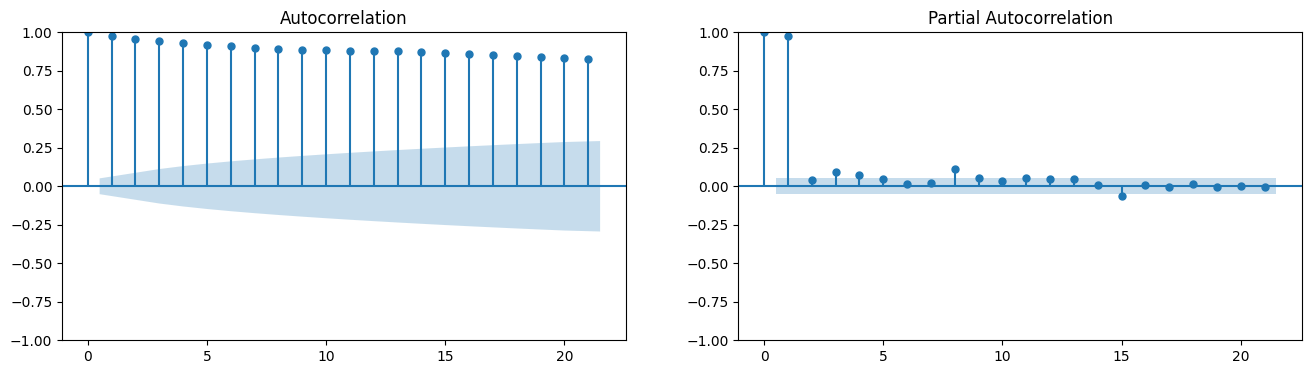

In [287]:
fig, axes = plt.subplots(1,2,figsize=(16,4), dpi= 100)
plot_acf(df_result_VR2['VR2'], lags = 21, ax=axes[0])
plot_pacf(df_result_VR2['VR2'], lags = 21, ax=axes[1])
plt.show()

По полученным графикам можно отметить следующее:
1. График Autocorrelation. Этот график показывает степень автокорреляции временного ряда на лагах от 1 до 21. Голубая область — это доверительный интервал. Если точки находятся внутри интервала, автокорреляция считается статистически незначимой.
На первом лаге видна сильная положительная корреляция (примерно 1), что согласуется с ранее рассчитанным значением автокорреляции, которая постепенно снижается, но находится за пределами голубой области и считается статистически значимой

2. График Partial Autocorrelation. График PACF показывают связь между текущим значением ряда и его значениями на определенном лаге, исключая влияние промежуточных лагов. 
Лаг 1 имеет высокое положительное значени, начиная со 2 лага и далее показатель снижается.

Источники:

[https://itsudit.medium.com/deciphering-acf-and-pacf-plots-a-guide-to-time-series-forecasting-3323948935fb]

[https://medium.com/analytics-vidhya/interpreting-acf-or-auto-correlation-plot-d12e9051cd14]

### 3.1.5. По каждому временному ряду разбейте выборку на обучающую и тестовую (обоснуйте выбор временного интервала для тестовой выборки). На основе обучающей выборки идентифицируйте параметры модели АРПСС (ARIMA) Какие параметры модели p, d и q Вы будете использовать и почему? Оцените качество модели. Насколько хорошо она предсказывает значения тестовой выборки?

In [48]:
split_date = '2020-07-01' # у нас данные за 4 года - возьмем 1 год в качестве тестовой выборки

train = df_result_VR2[df_result_VR2.index < split_date]

test = df_result_VR2[df_result_VR2.index >= split_date]

In [49]:
fig = go.Figure()

# Обучающая выборка (Train)
fig.add_trace(
    go.Scatter(
        x=train.index,
        y=train['VR2'],
        mode='lines',
        name='Обучающая выборка',
        line=dict(color='black')
    )
)

# Тестовая выборка (Test)
fig.add_trace(
    go.Scatter(
        x=test.index,
        y=test['VR2'],
        mode='lines',
        name='Тестовая выборка',
        line=dict(color='red')
    )
)

fig.update_layout(
    title='Обучающая и тестовая выборки по данным о сальдо операций Банка России по предоставлению / абсорбированию ликвидности',
    xaxis_title='Период',
    yaxis_title='млрд. рублей',
    height=500,
    width=1700
)

fig.show()


In [292]:
test

,VR2
Date,
2020-07-01,-2283.2
2020-07-02,-1760.8
2020-07-03,-1772.5
2020-07-04,-1772.3
2020-07-05,-1772.1
...,...
2021-06-26,-1033.2
2021-06-27,-1035.8
2021-06-28,-1038.4


### 3.1.6. Используя модель ARIMA, постройте прогноз 2-х временных рядов на 3 года вперёд от даты окончания временного диапазона (например, если у Вас временной диапазон 12.12.2013–29.12.2017, то до 29.12.2020, если у Вас временной диапазон 02.10.2017 – 17.11.2022, то до 17.11.2025), приведите их графики.

In [51]:
model = auto_arima(train["VR2"], trace=True, error_action='ignore', suppress_warnings=True)
res = model.fit(train["VR2"])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14893.240, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14937.583, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14935.214, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14933.645, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14935.735, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14892.081, Time=0.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=14914.517, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14892.510, Time=0.33 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=14893.004, Time=0.70 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=14911.565, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14892.323, Time=0.37 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=14891.066, Time=0.88 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=14884.132, Time=0.97 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=14891.797, Time=0.78 sec
 ARIMA(4,1,3)(0,0,0

Наилучшей моделью получилась модель ARIMA (ARIMA - это модель ARMA c p авторегрессионными лагами, q лагами скользящего среднего и дифференциацией порядка d.) p = 3, d = 1, q = 3.
Выбранные значения указывают, что наилучшая модель имеет следующие параметры:

- Количество авторегрессионными лагов = 3.
- Дифференциация первого порядка (данные подвергнуты одному дифференцированию - мы выявили тоже самое ранее, значит верно).
- Количество лагов скользящего среднего = 3.

In [52]:
forecast = res.predict(n_periods=365*3+1)

In [53]:
date_list = pd.date_range(start='2021-07-01', end='2024-06-30', freq='D')

In [54]:
forecast = forecast.reset_index()
forecast['date'] = date_list
forecast.set_index('date', inplace=True)
forecast = (forecast.drop(columns = "index"))
forecast.rename(columns={0: 'Predictions'}, inplace=True)

In [55]:
fig = go.Figure()

# Обучающая выборка (Train)
fig.add_trace(
    go.Scatter(
        x=train.index,
        y=train['VR2'],
        mode='lines',
        name='Train',
        line=dict(color='blue')
    )
)

# Тестовая выборка (Test)
fig.add_trace(
    go.Scatter(
        x=test.index,
        y=test['VR2'],
        mode='lines',
        name='Test',
        line=dict(color='orange')
    )
)

# Прогноз (Forecast)
fig.add_trace(
    go.Scatter(
        x=forecast.index,
        y=forecast["Predictions"],
        mode='lines',
        name='Prediction',
        line=dict(color='green')
    )
)

fig.update_layout(
    title='Прогнозные суммы сальдо операций Банка России по предоставлению / абсорбированию ликвидности',
    xaxis_title='Период',
    yaxis_title='млрд. рублей',
    height=500,
    width=1700
)

# Показ графика
fig.show()

Как мы видим, модель спрогнозировала небольшой скачок в начале, а в дальнейшем стабильно одно и то же значение

### 3.1.7. Проверьте с помощью соответствующих критериев адекватность (независимость и нормальность распределения остатков) каждой прогнозной модели для 2-х временных рядов, оцените качество прогнозной модели.

In [306]:
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1094
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -7434.254
Date:                Mon, 23 Dec 2024   AIC                          14882.507
Time:                        22:04:07   BIC                          14917.484
Sample:                    07-03-2017   HQIC                         14895.743
                         - 06-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8189      0.056    -14.751      0.000      -0.928      -0.710
ar.L2          0.2850      0.065      4.414      0.000       0.158       0.411
ar.L3          0.6364      0.064      9.892      0.0

Все переменные в модели (ar.L1, ar.L2, ar.L3, ma.L1, ma.L2, ma.L3 и sigma2) являются статистически значимыми, так как их p-value < 0.05.


- ar.L1 = -0.8189 коэффициент авторегрессии на лаге 1. Это означает, что текущее значение ряда имеет сильную отрицательную зависимость от первого лага;
- ar.L1 = -0.8189 коэффициент авторегрессии на лаге 2. Положительная зависимость от второго лага;
- ar.L1 =  0.6364 коэффициент авторегрессии на лаге 3. Значительная положительная зависимость от третьего лага;
- ma.L1 = 0.7268 коэффициент скользящего среднего на лаге 1;
- ma.L1 = -0.5279 коэффициент скользящего среднего на лаге 2;
- ma.L1 = -0.8231коэффициент скользящего среднего на лаге 3;
- sigma2 = 4.738e+04 . Это дисперсия остатков модели, она имеет высокое значение, что также связано с высокими значениями в данных о сальдо операций Банка России по предоставлению / абсорбированию ликвидности.

Оценить саму модель, к сожалению, не получится, так как спрогнозированные значения не имеют общих интервалов с тестовой выборкой. Поэтому мы оценим остатки

In [56]:
residuals = pd.DataFrame(res.resid())
residuals.index = pd.to_datetime(residuals.index)

# Создаем график остатков
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=residuals.index,
        y=residuals[0],
        mode='lines',
        name='Residuals',
        line=dict(color='blue')
    )
)

fig.update_layout(
    title='Остатки модели',
    xaxis_title='Период',
    yaxis_title='Млрд. рублей',
    height=500,
    width=1700
)

fig.show()


Остатки колеблются вокруг нуля, что является положительным признаком для модели. Это говорит о том, что модель в целом не систематически переоценивает или недооценивает прогнозы. Также наблюдаются выбросы в различные периоды, особенно в начале 2018 года и ближе к 2020 году.

<Axes: ylabel='Density'>

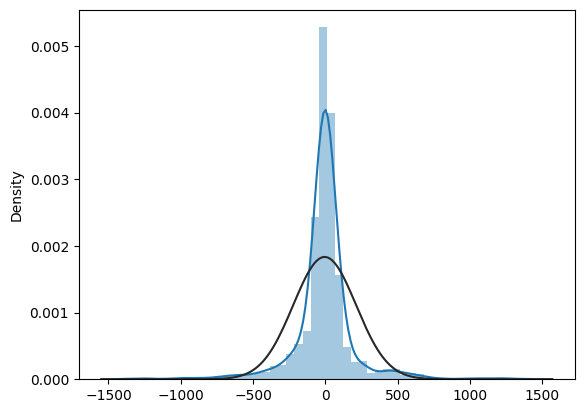

In [308]:
from scipy import stats 
sns.distplot(residuals, fit=stats.norm) 

По графику распределния остатков можно сказать следующее:

- Распределение остатков сильно заострено (остроконечное) — наблюдается высокий пик вблизи 0, что указывает на скопление значений вокруг среднего;
- Распределение имеет длинные хвосты, что говорит о наличии выбросов;
- Распределение симметрично, так как хвосты примерно одинаково распределены в обе стороны, что подтверждает отсутствие систематического смещения в остатках.
- По сравнению с нормальным распределением остатки имеют более высокий пик и более тяжёлые хвосты.

In [309]:
forecast.columns = ['VR2']

final_df = pd.concat([df_result_VR2["VR2"], forecast], ignore_index=False)
final_df.to_excel("Ex3_VR2_predictData.xlsx")